In [71]:
import numpy as np
import matplotlib.pyplot as plt
from lgca import get_lgca
from itertools import product
import pickle as pkl
import string
from itertools import cycle
PATH = '.\\data\\gog\\nonlocaldensity_10reps\\'
parameters = np.load(PATH+'params.npz', allow_pickle=True)

constparams = parameters['constparams'].item()
r_ds = parameters['r_ds']
thetas = parameters['thetas']
reps = 10
# data = np.load(PATH+'n_pr.npy', allow_pickle=True)
stepsize = 1
lgca = get_lgca(**constparams)

death rate set to r_d =  0.01
switch rate set to kappa =  5.0
switch threshold set to theta =  0.5


In [72]:
def label_axes(fig, labels=None, loc=None, **kwargs):
    """
    Walks through axes and labels each.

    kwargs are collected and passed to `annotate`

    Parameters
    ----------
    fig : Figure
         Figure object to work on

    labels : iterable or None
        iterable of strings to use to label the axes.
        If None, lower case letters are used.

    loc : len=2 tuple of floats
        Where to put the label in axes-fraction units
    """
    if labels is None:
        labels = string.ascii_uppercase

    # re-use labels rather than stop labeling
    labels = cycle(labels)
    if loc is None:
        loc = (-0.05, 1.15)
    for ax, lab in zip(fig.axes, labels):
        ax.annotate(lab, xy=loc, ha='right', weight='bold', size=10,
                    xycoords='axes fraction',
                    **kwargs)

In [35]:
def plot_kappa_spatiotemp(index, reps, lgca, PATH):
    mean_props = []
    for i in range(reps):
        p = PATH+'data{}.pkl'.format(index+(i, 0,))
        with open(p, 'rb') as f:
            d = pkl.load(f)
            mean_props.append(lgca.calc_prop_mean(d['nodes_t'], propname='kappa', props={'kappa': d['kappa']}))

    len(mean_props)
    mean_props = np.ma.array(mean_props)

    mean_prop = np.mean(mean_props, axis=0)
    std_prop = np.std(mean_props, axis=0)  # calculate the standard deviation of the mean
    # n_sample = np.sum(~mean_props.mask, axis=0)  # calculate the number of samples
    # std_mean = std_prop / np.sqrt(n_sample)  # calculate the standard error of the mean
    # Define the window size for the running average
    window_size = 5

    # Define the weights for the running average
    weights = np.repeat(1.0, window_size) / window_size

    # Apply the running average using convolution
    running_average_prop = np.convolve(mean_prop, weights, 'same')
    std_running_average_prop = np.convolve(std_prop, weights, 'same')
    # running_average_prop = np.ma.array(running_average_prop, mask=mean_prop.mask)
    # std_running_average_prop = np.ma.array(std_running_average_prop, mask=mean_prop.mask)

    # ax.plot(np.ma.array(mean_props).T, color='k', alpha=0.5, lw=.5)
    plt.plot([0, len(mean_prop)], [0, 0], 'k--')
    plt.plot(mean_prop, lw=1)
    # fill the area between the mean and the standard deviation
    plt.fill_between(np.arange(len(mean_prop)), mean_prop-std_prop, mean_prop+std_prop, alpha=.5)
    # plt.plot(running_average_prop)
    # plt.fill_between(np.arange(len(mean_prop)), running_average_prop-std_running_average_prop, running_average_prop+std_running_average_prop, alpha=.5)

In [43]:
def plot_migr_rest_spatiotemp(index, reps, lgca, PATH):
    nodes_t = np.empty((constparams['tmax'], constparams['l'], 3), dtype=object)
    lgca.props = {}
    migrating_cells = []
    resting_cells = []
    for i in range(reps):
        p = PATH+'data{}.pkl'.format(index+(i, 0,))
        with open(p, 'rb') as f:
            d = pkl.load(f)

        lgca.nodes = d['nodes_t']
        lgca.update_dynamic_fields()
        m = lgca.channel_pop[:, :lgca.velocitychannels].sum(-1)
        migrating_cells.append(m)
        resting_cells.append(lgca.cell_density - m)

    mean_migrating_cells = np.mean(migrating_cells, axis=0)
    std_migration = np.std(migrating_cells, axis=0) / np.sqrt(reps)
    mean_resting_cells = np.mean(resting_cells, axis=0)
    std_resting = np.std(resting_cells, axis=0) / np.sqrt(reps)
    plt.plot(mean_resting_cells, label='Resting cells')
    plt.fill_between(np.arange(len(mean_resting_cells)), mean_resting_cells-std_resting, mean_resting_cells+std_resting, alpha=.5)
    plt.plot(mean_migrating_cells, label='Migrating cells')
    plt.fill_between(np.arange(len(mean_migrating_cells)), mean_migrating_cells-std_migration, mean_migrating_cells+std_migration, alpha=.5)

In [25]:
import os
import matplotlib as mpl
style_path = os.path.abspath('./frontiers_style.mplstyle')
plt.style.use(style_path)
fig_size = mpl.rcParams['figure.figsize']
s = 0.7
fig_size[0] *= s
fig_size[1] *= s
mpl.rcParams['figure.figsize'] = fig_size

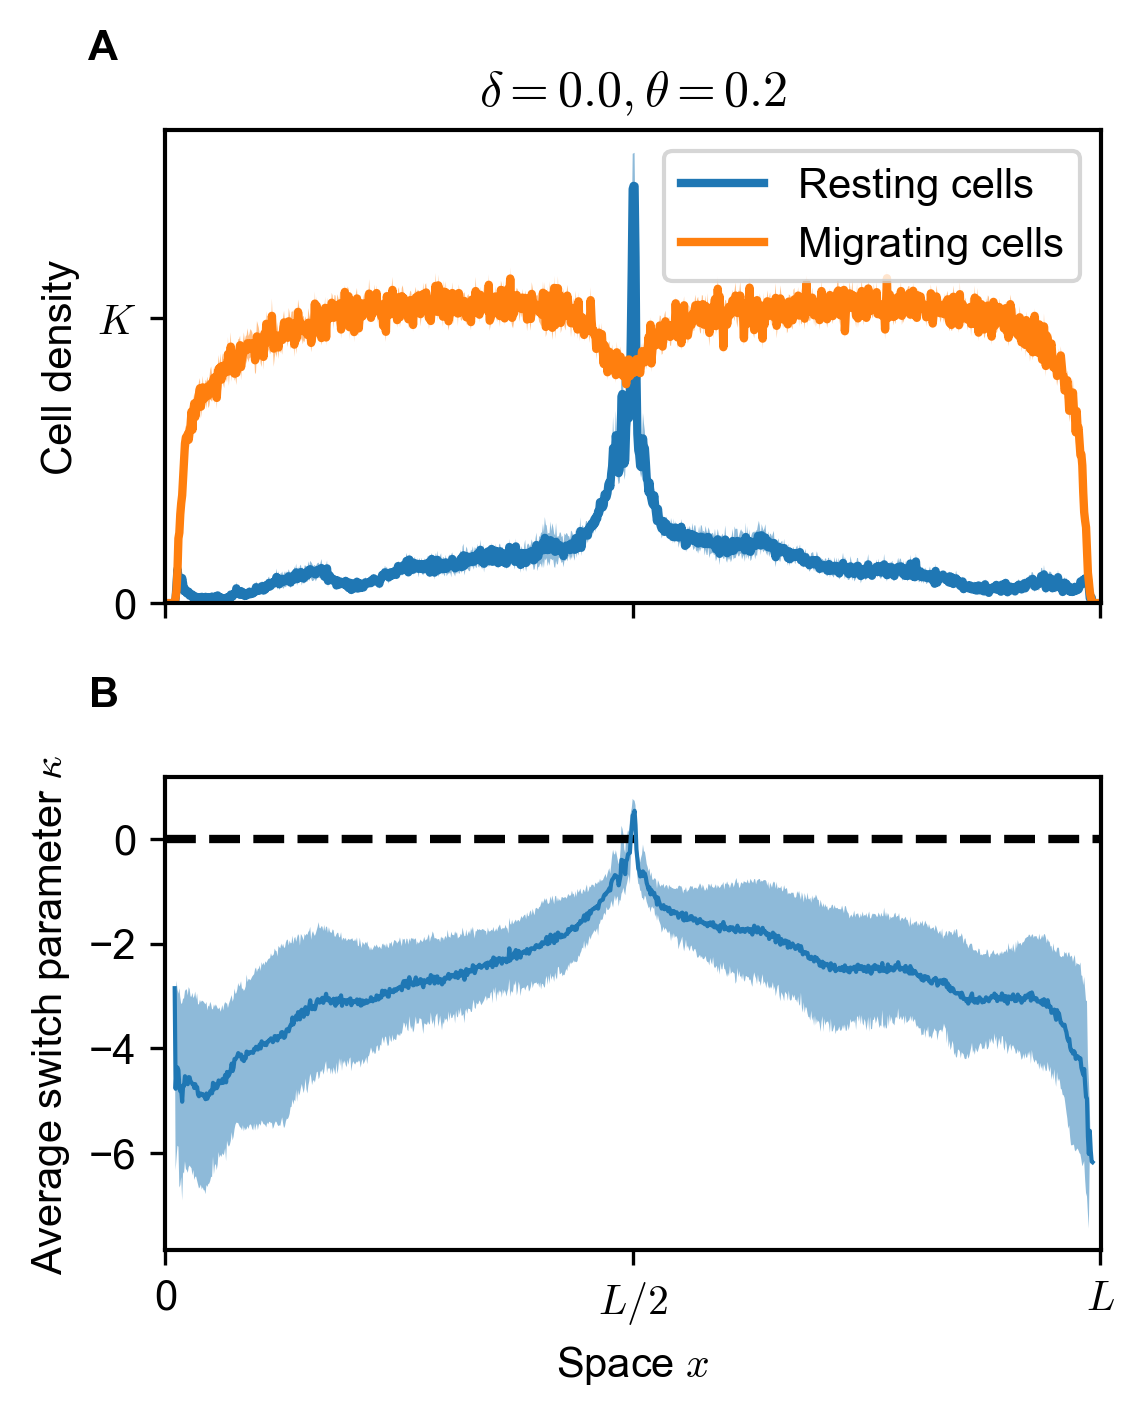

In [83]:
index = 0, 2
fig, axs = plt.subplots(2, 1, sharex=True)
figsize = fig.get_size_inches()
fig.set_size_inches(figsize[0], figsize[1]*2)
plt.sca(axs[0])
plot_migr_rest_spatiotemp(index, reps, lgca, PATH)
plt.title(r'$\delta={}, \theta={}$'.format(r_ds[index[0]], thetas[index[1]]))
plt.ylabel(r'Cell density')
plt.xlim(0, constparams['l'])
plt.yticks(ticks=[0, 100], labels=[0, r'$K$'])
plt.ylim(0)
plt.legend(loc='best')
plt.sca(axs[1])
plot_kappa_spatiotemp(index, reps, lgca, constparams, PATH)
plt.xlabel(r'Space $x$')
plt.ylabel(r'Average switch parameter $\kappa$')
plt.xlim(0, constparams['l'])
plt.xticks(ticks=[0, 500, 1000], labels=[0, r'$L/2$', r'$L$'])
label_axes(fig)
plt.tight_layout()
fig.savefig('spatial_kappa_region1.pdf', bbox_inches='tight')
fig.savefig('spatial_kappa_region1.svg', bbox_inches='tight')

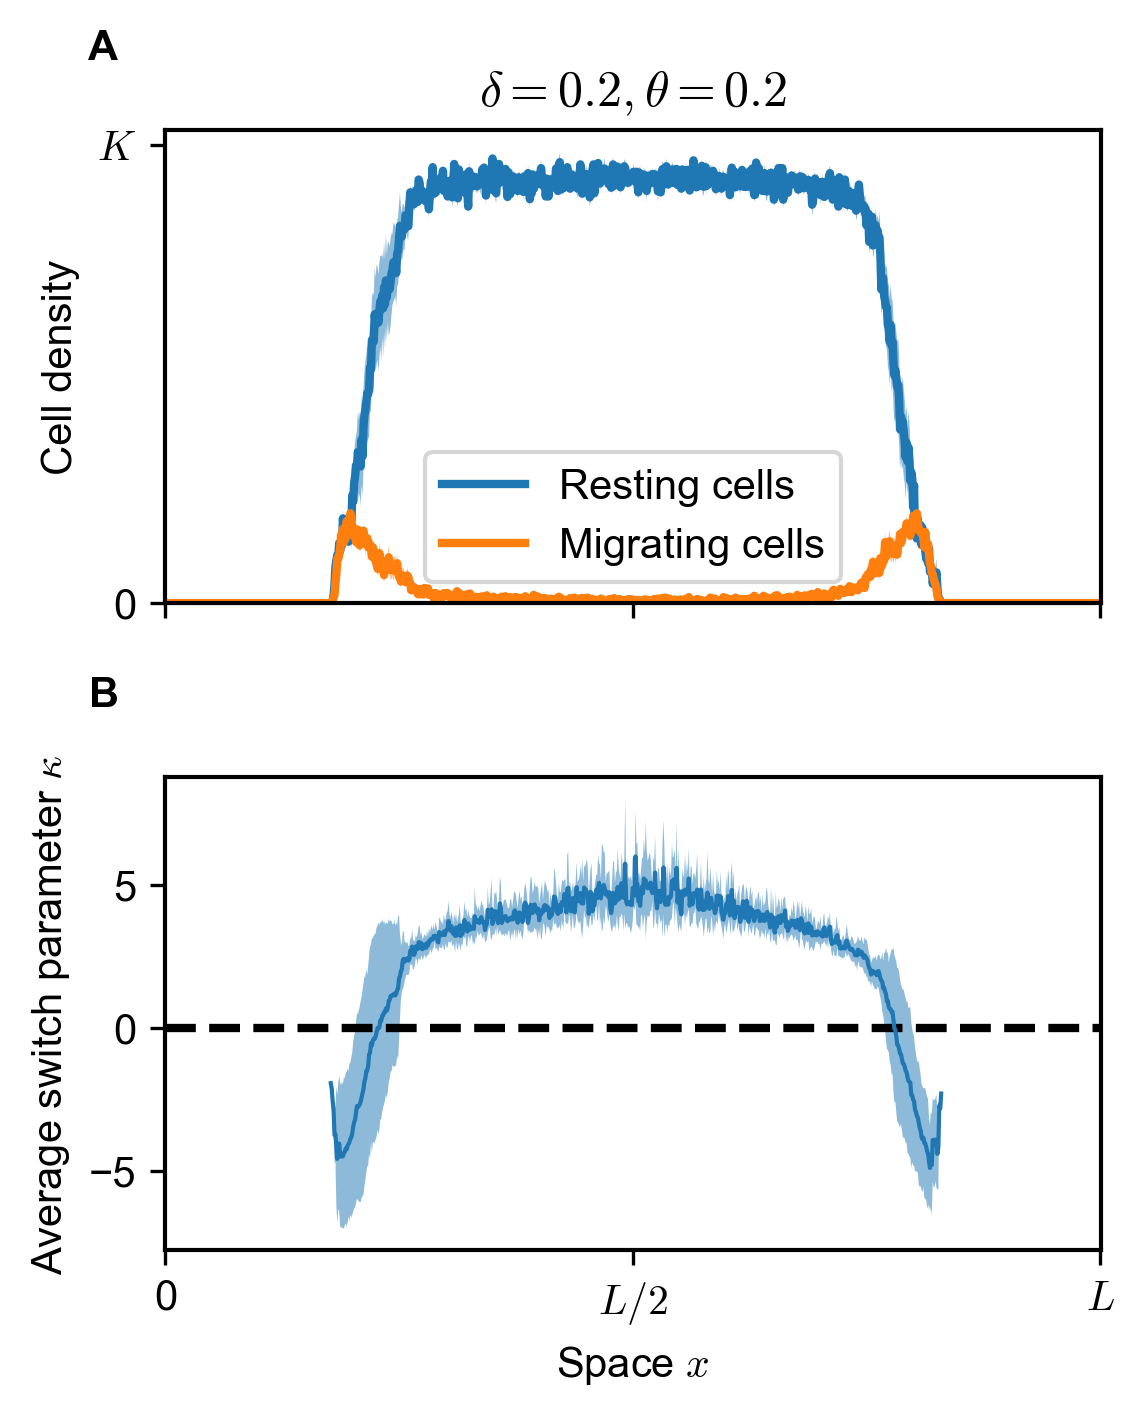

In [84]:
index = (4, 2)
fig, axs = plt.subplots(2, 1, sharex=True)
figsize = fig.get_size_inches()
fig.set_size_inches(figsize[0], figsize[1]*2)
plt.sca(axs[0])
plot_migr_rest_spatiotemp(index, reps, lgca, PATH)
plt.title(r'$\delta={}, \theta={}$'.format(r_ds[index[0]], thetas[index[1]]))
plt.ylabel(r'Cell density')
plt.xlim(0, constparams['l'])
plt.yticks(ticks=[0, 100], labels=[0, r'$K$'])
plt.ylim(0)
plt.legend(loc='best')
plt.sca(axs[1])
plot_kappa_spatiotemp(index, reps, lgca, constparams, PATH)
plt.xlabel(r'Space $x$')
plt.ylabel(r'Average switch parameter $\kappa$')
plt.xlim(0, constparams['l'])
plt.xticks(ticks=[0, 500, 1000], labels=[0, r'$L/2$', r'$L$'])
label_axes(fig)
plt.tight_layout()
fig.savefig('spatial_kappa_region2.pdf', bbox_inches='tight')
fig.savefig('spatial_kappa_region2.svg', bbox_inches='tight')

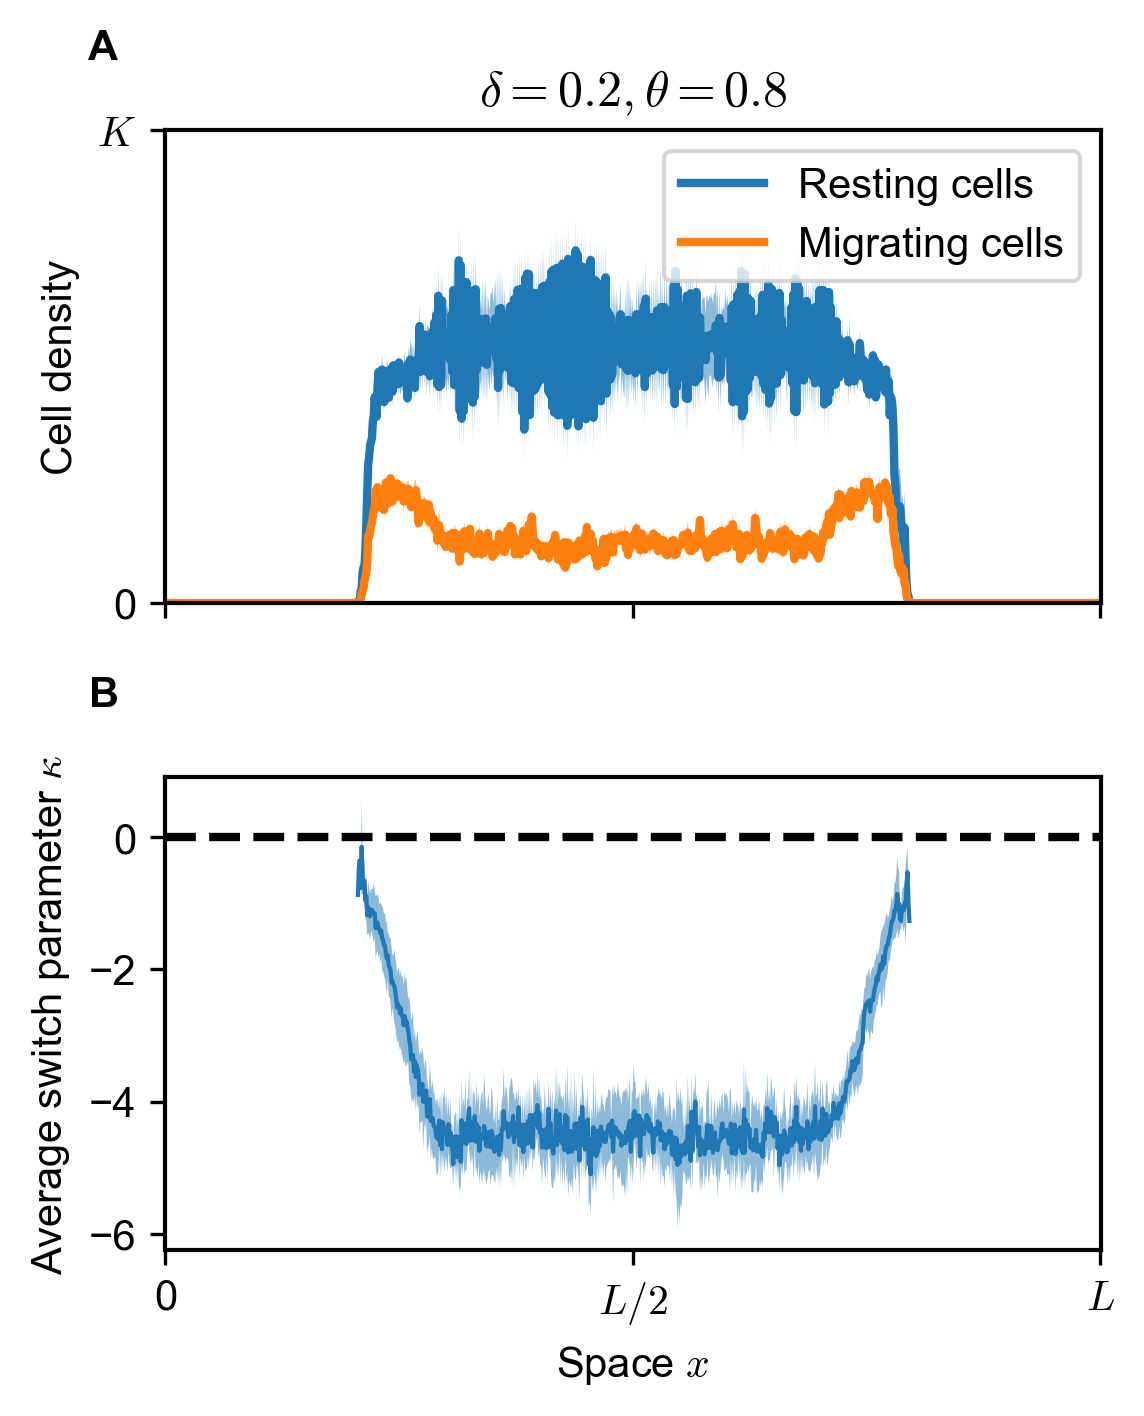

In [85]:
index = (4, 8)
fig, axs = plt.subplots(2, 1, sharex=True)
figsize = fig.get_size_inches()
fig.set_size_inches(figsize[0], figsize[1]*2)
plt.sca(axs[0])
plot_migr_rest_spatiotemp(index, reps, lgca, PATH)
plt.title(r'$\delta={}, \theta={}$'.format(r_ds[index[0]], thetas[index[1]]))
plt.ylabel(r'Cell density')
plt.xlim(0, constparams['l'])
plt.yticks(ticks=[0, 100], labels=[0, r'$K$'])
plt.ylim(0)
plt.legend(loc='best')
plt.sca(axs[1])
plot_kappa_spatiotemp(index, reps, lgca, constparams, PATH)
plt.xlabel(r'Space $x$')
plt.ylabel(r'Average switch parameter $\kappa$')
plt.xlim(0, constparams['l'])
plt.xticks(ticks=[0, 500, 1000], labels=[0, r'$L/2$', r'$L$'])
label_axes(fig)
plt.tight_layout()
fig.savefig('spatial_kappa_region3.pdf', bbox_inches='tight')
fig.savefig('spatial_kappa_region3.svg', bbox_inches='tight')

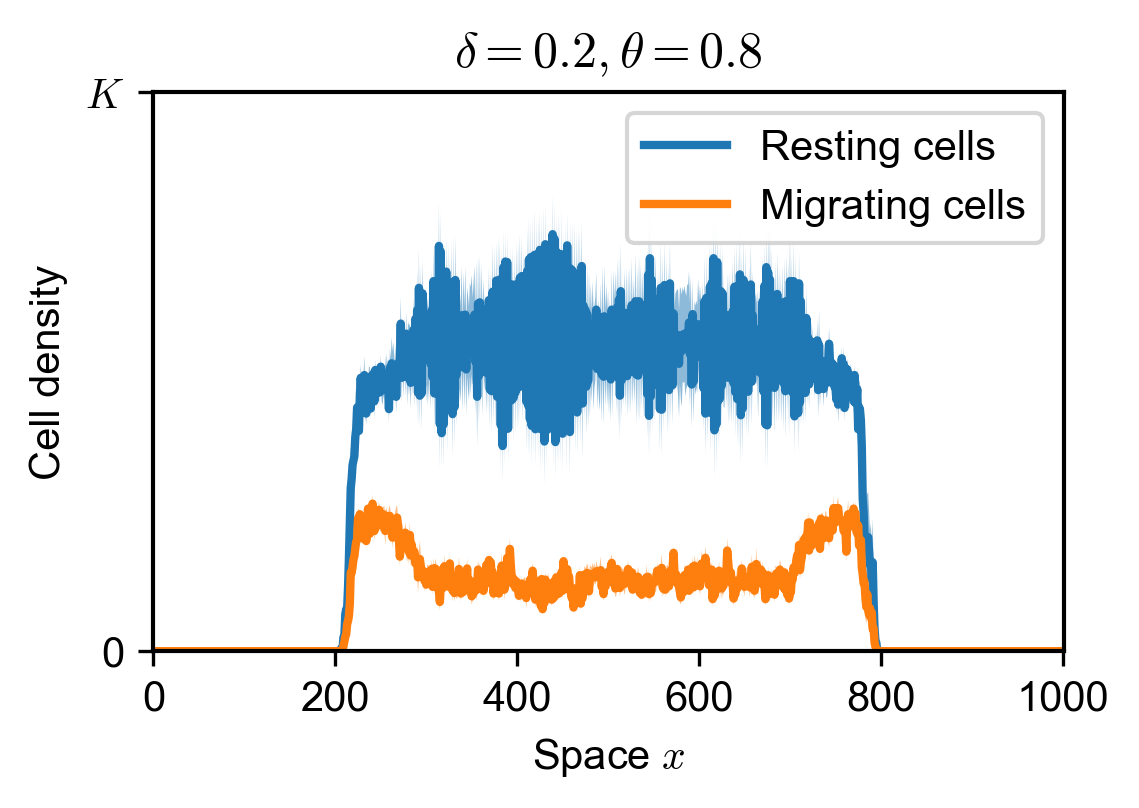

In [63]:
plot_migr_rest_spatiotemp(index, reps, lgca, PATH)
plt.title(r'$\delta={}, \theta={}$'.format(r_ds[index[0]], thetas[index[1]]))
plt.xlabel(r'Space $x$')
plt.ylabel(r'Cell density')
plt.xlim(0, constparams['l'])
plt.yticks(ticks=[0, 100], labels=[0, r'$K$'])
plt.ylim(0)
plt.legend(loc='best')
plt.savefig('spatial_density_region3.pdf', bbox_inches='tight')
plt.savefig('spatial_density_region3.svg', bbox_inches='tight')